# Maximize revenue from direct marketing campaigns

This report analyses the customer data to find trends and make predictions on various marketing offers like Customer loan, Credit cards and Mutual funds by designing probabilistic models. These models will be used by the bank to determine the propensity of a client to buy a marketing offer and thus target the clients with the highest propensity to maximize the revenue. 

The various questions answered in this analysis are: -<br>
•	Which clients have higher propensity to buy consumer loan? <br>
•	Which clients have higher propensity to buy credit card? <br>
•	Which clients have higher propensity to buy mutual fund?<br> 
•	Which clients should be targeted with which offer?  
•	What would be the expected revenue based on the analysis?

<b>Import the required libraries </b>

In [286]:
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

This function maps the probability values (Propensity) calculated by the models with the Corresponding Dataframe

In [2]:
def map_score(dataframe,customers,prob):
    dataframe['Propensity'] = 0
    for i in range(len(dataframe)):
        idx = dataframe.index[i]
        for j in range(len(customers)):
            if dataframe.loc[idx,'Client'] == customers[j]:
                dataframe.loc[idx, "Propensity"] = prob[j]
            

The consolidated view which was created in Task A2 was exported from MYSQL and used as a dataset to do feature engineering
and predicted analysis using Machine Learning libraries

In [3]:
df_kbc_bank = pd.read_csv("C:\Data Analytics\KBC\main.csv")


In [4]:
# Returns the first five records,it is very useful to understand the Trends of the Data
df_kbc_bank.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1,F,51,7,1,0,0,1,0,0,...,30.0,3.0,12.0,9.0,1.0,0.0,0.0,26.972679,0.0,0.0
1,2,M,43,152,1,1,0,0,0,0,...,6.0,2.0,2.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,3,M,17,140,1,0,1,0,0,0,...,3.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,M,24,153,1,1,0,0,1,0,...,36.0,6.0,12.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,F,58,200,1,1,0,0,0,0,...,41.0,4.0,17.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Shape Function tells us about the number of rows and columns in the dataset
df_kbc_bank.shape

(1615, 36)

Create a dataset to capture the number of positive sale target values to understand the requirement of the consumers

In [160]:
cust_req = pd.DataFrame({'Category': {0: 'Credit', 1: 'Loan',2:'Mutual Fund'}, 'Sum': {0: float(df_kbc_bank[["Sale_CC"]].sum()),
1:float(df_kbc_bank[["Sale_CL"]].sum()),2:float(df_kbc_bank[["Sale_MF"]].sum()) }})

Plotting the Positive Sales Target ( i.e the Customers who are interested in a paritcular marketing scheme)

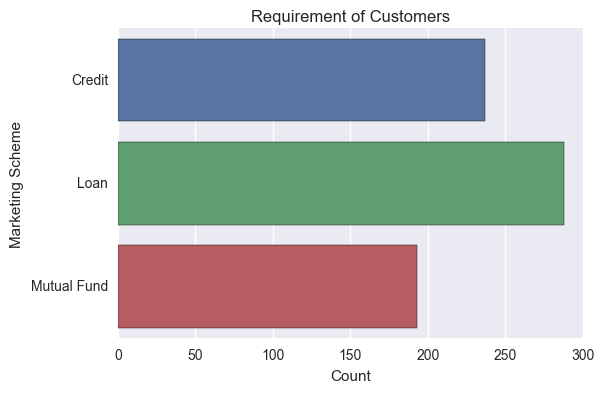

In [161]:
sns.barplot(x = 'Sum', y = 'Category', data = cust_req)
plt.title('Requirement of Customers')
plt.xlabel('Count')
plt.ylabel('Marketing Scheme')

As we need to do three different analysis and we have to choose between 35 columns, the first stage would be to break the columns as per the required fields for predcictions.

<b>Which clients have higher propensity to buy consumer loan? </b>

Correlation of Sale_CL with other attributes are computed to decide the features which will be used for prediction

It is very important to remove the Null attributes as only 969 entries are available for modeling

In [163]:
df_kbc_bank = df_kbc_bank.dropna()
corr = df_kbc_bank.corr()
corr.sort_values(["Sale_CL"], ascending = False, inplace = True)
print(corr.Sale_CL)

Sale_CL                         1.000000
Revenue_CL                      0.709623
Tenure                          0.182954
TransactionsCred_CA             0.084930
TransactionsCred                0.083528
Count_CA                        0.083067
TransactionsDebCash_Card        0.076641
ActBal_MF                       0.073530
TransactionsDeb                 0.068460
ActBal_OVD                      0.066445
TransactionsDeb_CA              0.064593
VolumeDeb                       0.061754
Count_CL                        0.052065
VolumeDeb_PaymentOrder          0.051462
ActBal_CL                       0.050732
TransactionsDeb_PaymentOrder    0.049147
Client                          0.044932
Count_MF                        0.044770
VolumeDeb_CA                    0.039795
VolumeDebCashless_Card          0.038015
Count_OVD                       0.035477
Count_SA                        0.028808
VolumeDebCash_Card              0.015739
TransactionsDebCashless_Card    0.014826
Revenue_MF      

Based on the above list we can choose the fields which are correlated and hence can be used to make the prediction
Note: Revenue_CL being a target variable is not choosen although it shows a strong correlation

A subset of the main dataset is created to include only those features that will be required for mapping, The client field is also included as it can be used to identify the Client for which the predictions are made 

In [342]:
data_loan = df_kbc_bank[['Tenure','TransactionsCred_CA','Count_CA','TransactionsCred','TransactionsDebCash_Card','ActBal_CC','Age','Client','Sale_CL','Revenue_CL']]

X is the array which contains the features and Y contains the Target Value to be predicted

In [343]:
X = data_loan.ix[:,'Tenure':'Client'].as_matrix()
y = data_loan.Sale_CL.as_matrix()

The Correlation can be visualized using a Correlation matrix heatmap 

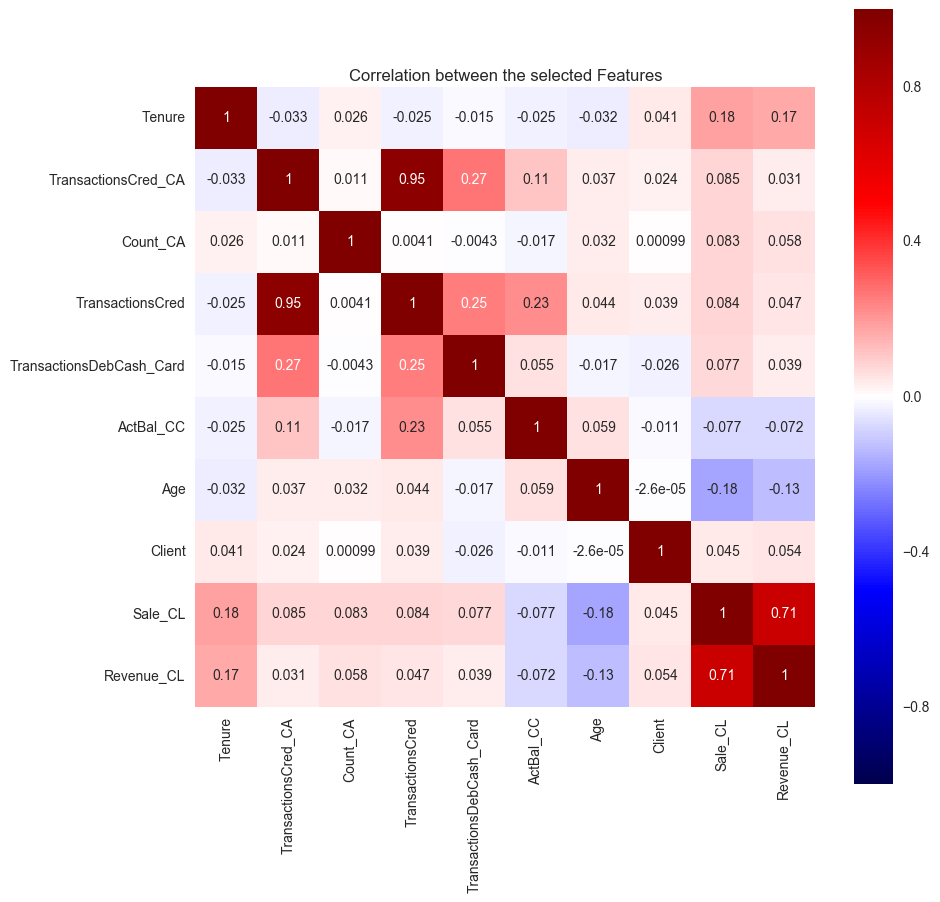

In [344]:
Corr_Loan = data_loan.corr()
plt.figure(figsize=(10,10))
sns.heatmap(Corr_Loan, vmax=1, square=True,annot=True,cmap='seismic')

plt.title('Correlation between the selected Features')

Creating the analytical Datasets require splitting the data into training and testing datasets, to ensure that our model
is not overfitted we use a method Consolidated_dataed as the Cross validation which is a randomized selection of training and testing datasets 

Test size is choosen as 0.15 as the requirement specified that the bank can contact only 15 % customer ( hence act based on the predictions made on the testing dataset )

In [345]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size=0.15, random_state=42)

The technique used to model the Sales of Customer Loan is Logistic Regression which is a classification algorithm 
Since we are using Sklearn library, it is regularized by default, yet we are passing the values to show the usage.
Class weight is choosen as 'balanced' to improve the model prediction accuracy

In [346]:
logistic = linear_model.LogisticRegression(penalty='l2',C=1,class_weight='balanced')
logistic = logistic.fit(X_train, y_train)
print("Accuracy = "+str(logistic.score(X_test,y_test)))


Accuracy = 0.629370629371


The accuracy obtained is 62.93 %, now the propensity for the Test Cases will be calculated to determine which customers to contact

In [201]:
pscore = logistic.predict_proba(X_test)[:,1] # The predicted propensities by the model

Slicing the Test Data to get only the last column which has the client Details, this is required to link the Propensity calculated with each customer

In [202]:
Clients = X_test[:,-1]

The map_score function assigns the propensity of each client to buy the consumer loan

In [203]:
map_score(data_loan,Clients,pscore)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Now to make decision we need to remove the values where the Sale_CL is 0 ( Target 0) as we need to contact only those customer
who are suitable candidates for loan. The results are exported to a CSV file

In [204]:
# Remove records where the Target sale value is 0
data_loan =data_loan[(data_loan.Sale_CL != 0)]
# Remove cases where probability is 0
data_loan = data_loan[(data_loan.Propensity != 0)]
# Remove the non essential fields 
data_loan = data_loan[['Client','Sale_CL','Revenue_CL','Propensity']]
# Sort the values by Decreasing order of Propensity, so that the clients with the highest propensity can be targeted first
Clients_loan = data_loan.sort_values(by ='Propensity',ascending=False)
# Export the results to a CSV file
Clients_loan.to_csv('Clients_loan.csv',index=False)

An overview of the Result 

In [205]:
data_loan

,Client,Sale_CL,Revenue_CL,Propensity
101,102,1.0,6.952500,0.848873
119,120,1.0,7.297857,0.374877
122,123,1.0,10.461071,0.543313
191,192,1.0,6.857143,0.280950
387,388,1.0,7.285714,0.489054
414,415,1.0,27.257500,0.481609
454,455,1.0,10.571429,0.288196
469,470,1.0,10.607143,0.291578
500,501,1.0,15.952143,0.225270
514,515,1.0,13.033929,0.421091


<b>Which clients have higher propensity to buy credit card?</b> 

As with the previous case, the correlation dataframe created earlier is now sorted by Sale_CC which is the<br>
target variable for Credit card Sale, this is needed to determine the features to use for modeling

In [194]:
corr.sort_values(["Sale_CC"], ascending = False, inplace = True)
print(corr.Sale_CC)

Sale_CC                         1.000000
Revenue_CC                      0.266128
ActBal_SA                       0.178872
ActBal_CA                       0.162126
Count_SA                        0.109100
VolumeDeb_PaymentOrder          0.078926
TransactionsDebCash_Card        0.067147
Revenue_CL                      0.061286
VolumeDeb                       0.056011
VolumeDeb_CA                    0.048978
Count_OVD                       0.045900
Age                             0.044275
TransactionsCred                0.033397
Tenure                          0.015186
VolumeCred                      0.015178
TransactionsCred_CA             0.007702
TransactionsDeb                -0.000098
Revenue_MF                     -0.001863
VolumeCred_CA                  -0.002583
Client                         -0.003112
TransactionsDeb_CA             -0.009415
VolumeDebCash_Card             -0.009527
TransactionsDeb_PaymentOrder   -0.009810
Count_CC                       -0.011186
VolumeDebCashles

We will now pick the fields which are correlated with our target variable<br>
Note: Revenue_CC is excluded as it is a target variable

In [206]:
data_credit = df_kbc_bank[['ActBal_SA','ActBal_CA','Count_SA','VolumeDeb_PaymentOrder','TransactionsDebCash_Card','ActBal_CC','Count_CC','Client','Sale_CC','Revenue_CC']]

X is the array which contains the features and Y contains the Target Value to be predicted

In [207]:
X = data_credit.ix[:,'ActBal_SA':'Client'].as_matrix()
y = data_credit.Sale_CC.as_matrix()

Similar to the previous case, the Correlation matrix is plotted using the heatmap function

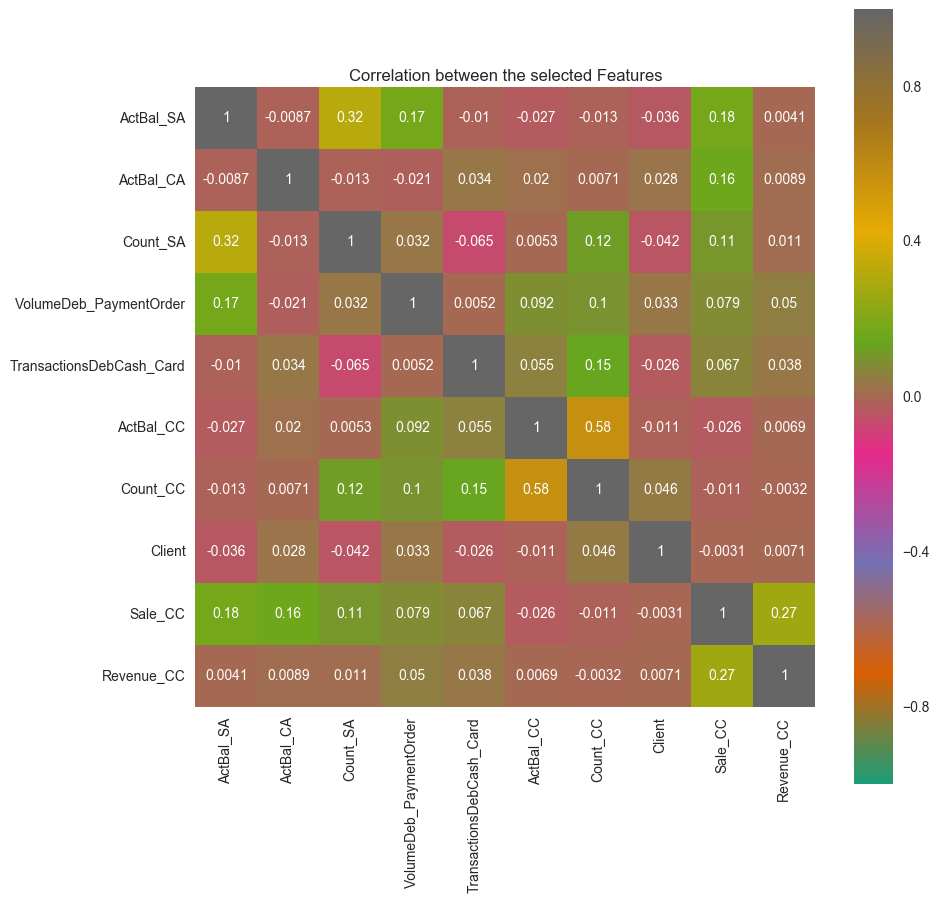

In [208]:
Corr_Credit = data_credit.corr()
plt.figure(figsize=(10,10))
sns.heatmap(Corr_Credit, vmax=1, square=True,annot=True,cmap='Dark2')

plt.title('Correlation between the selected Features')

The training and testing data of the input is then created using the train_test_split function of cross_validation library of sklearn

The Random Forest classifier is basically a collection of n random Decision trees (hence the name "RandomForest" )<br>
it ensures that the model is not overfitted. It is thus termed as an ensemble learning tecnique

In [248]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size=0.15, random_state=42)
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))

0.79020979021


The Accuracy score computed by the model is 79 % , although it could further be tweaked with feature engineering, it is a good<br>
enough prediction to estimate the Credit card propensity of clients

The probability score of the test values is then computed to determine the propensity of customers interesed in credit cards

In [253]:
pscore = clf.predict_proba(X_test)[:,1]
# The list of clients to be mapped to the propensity score calculated
Clients = X_test[:,-1]

The function to map the propensity score with the Credit card Dataset

In [254]:
map_score(data_credit,Clients,pscore)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Now to make decision we need to remove the values where the Sale_CC is 0 ( Target 0) as we need to contact only those customer
who are suitable candidates for buying credit card. The results are then exported to a CSV file

In [255]:
# Remove records where the Target sale value is 0
data_credit =data_credit[(data_credit.Sale_CC != 0)]
# Remove cases where probability is 0
data_credit = data_credit[(data_credit.Propensity != 0)]
# Remove the non essential fields 
data_credit = data_credit[['Client','Sale_CC','Revenue_CC','Propensity']]
# Sort the values by Decreasing order of Propensity, so that the clients with the highest propensity can be targeted first
Clients_credit = data_credit.sort_values(by ='Propensity',ascending=False)
# Export the results to a CSV file
Clients_credit.to_csv('Clients_credit.csv',index=False)

An overview of the output

In [256]:
Clients_credit

,Client,Sale_CC,Revenue_CC,Propensity
48,49,1.0,15.246429,0.8
1537,1538,1.0,1.714286,0.8
384,385,1.0,4.500000,0.7
454,455,1.0,18.292143,0.7
1366,1367,1.0,5.177143,0.6
1301,1302,1.0,0.428571,0.6
617,618,1.0,18.571429,0.6
926,927,1.0,3.569286,0.5
373,374,1.0,76.859286,0.5
648,649,1.0,3.000000,0.5


<b>Which clients have higher propensity to buy mutual fund?</b>

Similar to the previous cases the Correlation dataframe is sorted with respect to target value of mutual fund and sorted<br>
to determine the features to be selected for modeling

In [258]:
corr.sort_values(["Sale_MF"], ascending = False, inplace = True)
print(corr.Sale_MF)

Sale_MF                         1.000000
Revenue_MF                      0.387523
Count_MF                        0.164022
TransactionsDebCashless_Card    0.124785
TransactionsDeb                 0.082344
TransactionsCred_CA             0.081178
TransactionsCred                0.073415
TransactionsDeb_CA              0.053990
ActBal_MF                       0.024952
TransactionsDeb_PaymentOrder    0.023112
VolumeCred_CA                   0.015664
Client                          0.011345
ActBal_CC                       0.010573
Revenue_CL                      0.004459
VolumeDebCashless_Card          0.002175
Count_CA                        0.001232
ActBal_OVD                     -0.001809
TransactionsDebCash_Card       -0.002194
Count_CC                       -0.003033
VolumeCred                     -0.003425
Tenure                         -0.005661
Count_SA                       -0.006532
Count_OVD                      -0.012146
VolumeDeb_PaymentOrder         -0.012781
Sale_CL         

A subset of the main dataset is created to include only those features that will be required for mapping, The client field is also included as it can be used to identify the Client for which the predictions are made 

In [375]:
data_mutual_fund = df_kbc_bank[['Count_MF','TransactionsDebCashless_Card','TransactionsDeb','TransactionsCred_CA'             
,'TransactionsCred','TransactionsDeb_CA','ActBal_MF',
'TransactionsDeb_PaymentOrder','VolumeCred_CA','Client','Sale_MF','Revenue_MF']]

X is the array which contains the features and Y contains the Target Value to be predicted

In [376]:
X = data_mutual_fund.ix[:,'Count_MF':'Client'].as_matrix()
y = data_mutual_fund.Sale_MF.as_matrix()

The Correlation matrix is plotted using the heatmap function

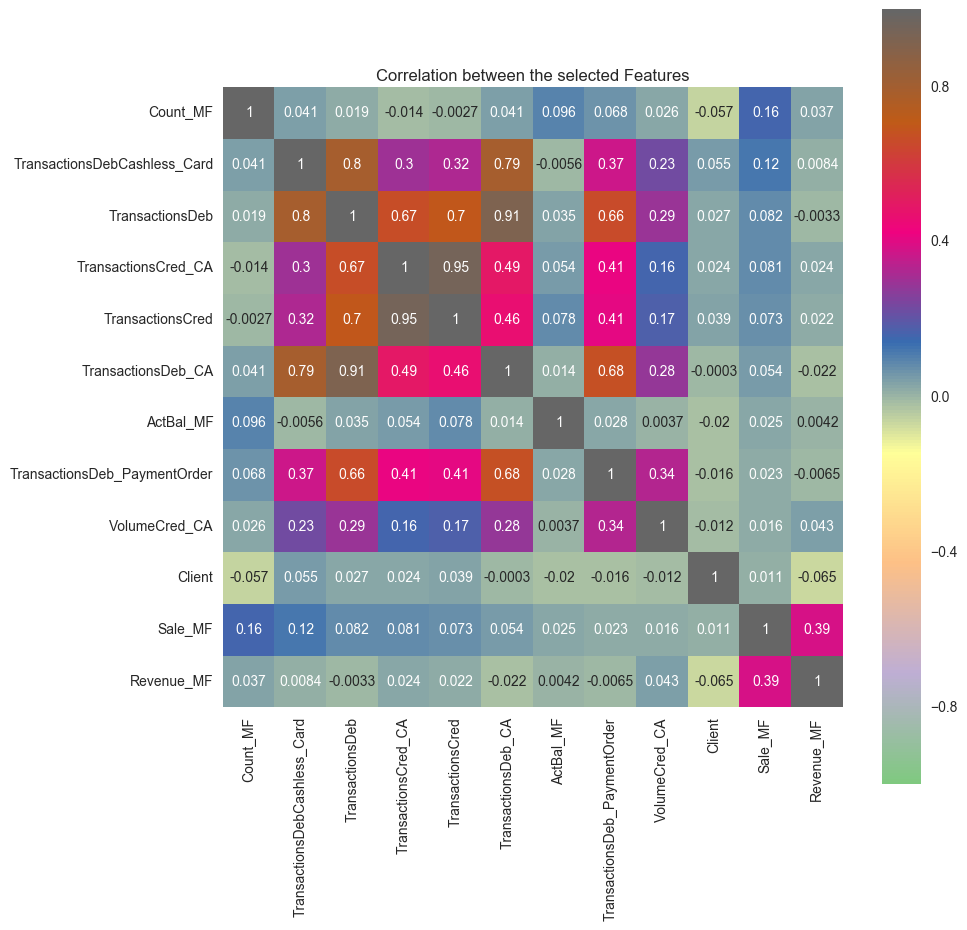

In [377]:
Corr_Mutual_Fund = data_mutual_fund.corr()
plt.figure(figsize=(10,10))
sns.heatmap(Corr_Mutual_Fund, vmax=1, square=True,annot=True,cmap='Accent')

plt.title('Correlation between the selected Features')

The training and testing data of the input is then created using the train_test_split function of cross_validation library of sklearn<br>
Naive Bayes works based on Bayes rule which computes the posterior probability of an event based on the prior probability,<br>
it has many methods such as GaussianNB(),MultinomialNB() and BernoulliNB().<br>
In this case GaussianNB was choosen it is suitable for binary events and out target value is Binary(0/1)

In [415]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size=0.15, random_state=42)
clf = GaussianNB()
clf.fit(X_train,y_train)

GaussianNB()

In [416]:
print(clf.score(X_test,y_test))

0.713286713287


An accuracy of 71.32 % was obtained by modeling using this method<br>
Probability score of the test dataset is then computed based on the model

In [417]:
pscore = clf.predict_proba(X_test)[:,1]

The propensity thus calculated is mapped with the client details of the Mutual fund data using the map function

In [392]:
Clients = X_test[:,-1]
map_score(data_mutual_fund,Clients,pscore)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [393]:
# Remove records where the Target sale value is 0
data_mutual_fund =data_mutual_fund[(data_mutual_fund.Sale_MF != 0)]
# Remove cases where probability is 0
data_mutual_fund = data_mutual_fund[(data_mutual_fund.Propensity != 0)]
# Remove the non essential fields 
data_mutual_fund = data_mutual_fund[['Client','Sale_MF','Revenue_MF','Propensity']]
# Sort the values by Decreasing order of Propensity, so that the clients with the highest propensity can be targeted first
Clients_mutual_fund = data_mutual_fund.sort_values(by ='Propensity',ascending=False)
# Export the results to a CSV file
Clients_mutual_fund.to_csv('Clients_mutual_fund.csv',index=False)

Overview of the output

In [394]:
Clients_mutual_fund

,Client,Sale_MF,Revenue_MF,Propensity
1495,1496,1.0,5.771250,0.6
766,767,1.0,0.686964,0.6
1301,1302,1.0,10.126429,0.6
1229,1230,1.0,1.547500,0.4
1157,1158,1.0,1.656250,0.4
926,927,1.0,9.385714,0.4
208,209,1.0,0.260714,0.4
130,131,1.0,3.138929,0.4
597,598,1.0,0.163571,0.4
546,547,1.0,2.142321,0.4


<b>Best Case Scenario</b><br>
Revenue generated from the sale of Credit card,Consumer Loan and Mutual Fund

In [305]:
print("Revenue From sale of Credit Card   = " +str(data_credit.Revenue_CC.sum()))
print("Revenue From sale of Consumer Loan = " +str(data_loan.Revenue_CL.sum()))
print("Revenue From sale of Mutual Fund   = " +str(data_mutual_fund.Revenue_MF.sum()))

Revenue From sale of Credit Card   = 265.634285708
Revenue From sale of Consumer Loan = 497.7578571720001
Revenue From sale of Mutual Fund   = 265.49410713699996


<b>Total Revenue</b> for the Best Case Scenario, i.e the case where all targeted customers with a Target Sale Value of 1 are
assumed to buy the marketing scheme on offer

In [306]:
print("Total best case Revenue = " +str(data_credit.Revenue_CC.sum() + data_loan.Revenue_CL.sum() + data_mutual_fund.Revenue_MF.sum()))

Total best case Revenue = 1028.886250017


Modification in the original datasets to consolidate the results for further analysis

In [307]:
data_credit.rename(columns={'Revenue_CC': 'Revenue'}, inplace=True)
data_loan.rename(columns={'Revenue_CL': 'Revenue'}, inplace=True)
data_mutual_fund.rename(columns={'Revenue_MF': 'Revenue'}, inplace=True)

Create a dataset which will have the consolidated results of the three models, this will be used for visualizing the result<br>
and to determine the ideal case scenario for market revenue

In [310]:
Consolidated_data = data_credit[["Client","Revenue",'Propensity']].copy()
Consolidated_data['Category'] = 'Credit'
Consolidated_data = Consolidated_data.append(data_loan)
Consolidated_data = Consolidated_data[['Category','Client','Revenue','Propensity']]
Consolidated_data = Consolidated_data.fillna('Loan')
Consolidated_data = Consolidated_data.append(data_mutual_fund)
Consolidated_data = Consolidated_data[['Category','Client','Revenue','Propensity']]
Consolidated_data = Consolidated_data.fillna('mutual_fund')

In [311]:
Consolidated_data['Category'].value_counts()

Loan           44
mutual_fund    33
Credit         27
Name: Category, dtype: int64

# Visualizing the results

Scatter plot between the Revenue and the propensity of customers for all the three categories

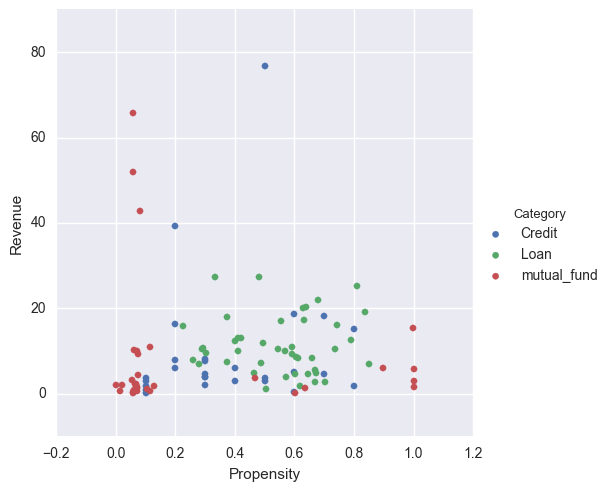

In [312]:
sns.FacetGrid(Consolidated_data, hue="Category", size=5) \
   .map(plt.scatter, "Propensity", "Revenue") \
   .add_legend()

The violin plot is a combination of a box plot and the density plot <br>
The thick black bar in the center represents the interquartile range, the advantage of using this plot is that we can visualize the spread of the data 

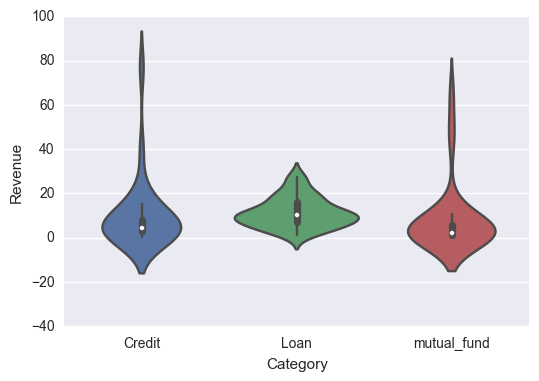

In [314]:
sns.violinplot(x="Category", y="Revenue", data=Consolidated_data, size=6)

Some more visualization to see the trends of the outputs

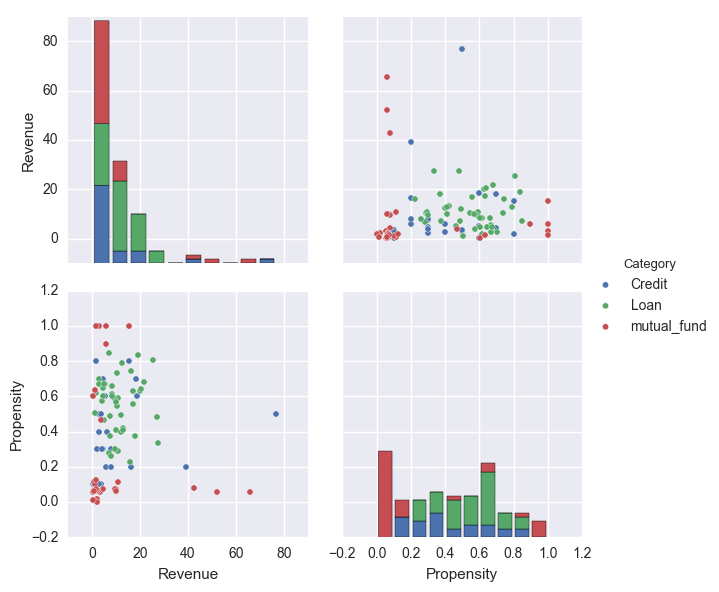

In [316]:
sns.pairplot(Consolidated_data.drop("Client", axis=1), hue="Category", size=3)

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


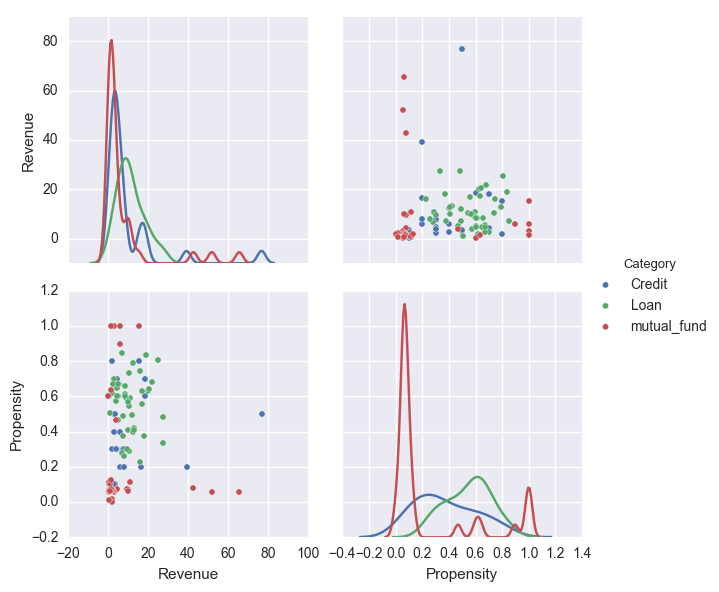

In [315]:
sns.pairplot(Consolidated_data.drop("Client", axis=1), hue="Category", size=3, diag_kind="kde")

# Strategy to Maximize revenue 
The basic assumption I have made is that the offers made to customers having higher propensity of buying a particular scheme<br>
will result in higher revenue, this can be ensured by setting a limit. In this case, the limit is the propensity score of 0.60,<br>
i.e all customers with a propensity score >= 0.60 will be called and made an offer according to the Category they are listed upon

In [318]:
CallTheseClients = Consolidated_data[(Consolidated_data.Propensity>=0.60)]
CallTheseClients = CallTheseClients.sort_values(by =['Category','Propensity'],ascending=False)
CallTheseClients

,Category,Client,Revenue,Propensity
101,mutual_fund,102,2.958036,1.000000
1229,mutual_fund,1230,1.547500,0.999995
1495,mutual_fund,1496,5.771250,0.999851
41,mutual_fund,42,15.275714,0.999811
1316,mutual_fund,1317,5.987679,0.896646
910,mutual_fund,911,1.269643,0.634898
597,mutual_fund,598,0.163571,0.601549
101,Loan,102,6.952500,0.848873
774,Loan,775,19.035714,0.836224
1297,Loan,1298,25.243214,0.808870


Now that we have the Propensity scores for customers to be contacted for Credit cards, Loans and mutual funds, 
we can calculate the Expected Revenue 

For contacting the customers there should be a reasonable probability that the customer should be interested 
in our case we will set that probability ( propensity ) to be 0.6 ,i.e contact only those customers out of the
testing data (the 15 % lot that the bank can contact) who are likely to buy the scheme ( Sale_XX target variable = 1)
and Propensity >= 0.6 (likely)

Expected Revenue is calculated by grouping the data by Category and summing the Revnue

In [325]:
Expected_Revenue = CallTheseClients.groupby(by=['Category'],as_index=False)['Revenue'].sum()
print("Expected Revenue From sale of Credit Card   = " +str(Expected_Revenue['Revenue'].iloc[0]))
print("Expected Revenue From sale of Consumer Loan = " +str(Expected_Revenue['Revenue'].iloc[1]))
print("Expected Revenue From sale of Mutual Fund   = " +str(Expected_Revenue['Revenue'].iloc[2]))

Expected Revenue From sale of Credit Card   = 63.93
Expected Revenue From sale of Consumer Loan = 221.583928589
Expected Revenue From sale of Mutual Fund   = 32.973392861


In [327]:
print("Combined Expected Revenue = " +str(CallTheseClients['Revenue'].sum()))

Combined Expected Revenue = 318.48732144999997


Finally the clients to be contacted are exported to CSV file

In [331]:
CallTheseClients.to_csv('CallTheseClients.csv',index=False)